In [1]:
# Visualization Demo
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.autograd import Variable

import transforms as transforms
from skimage import io
from skimage.transform import resize
from models import *
import warnings

warnings.filterwarnings('ignore')

cut_size = 44

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


In [2]:
# Raw image info
pic_name = 'MonaLisa'
raw_img = io.imread('images/'+str(pic_name)+'.jpg')

In [3]:
# Raw image preprocess
gray = rgb2gray(raw_img)
gray = resize(gray, (48,48), mode='symmetric').astype(np.uint8)

img = gray[:, :, np.newaxis]

img = np.concatenate((img, img, img), axis=2)
img = Image.fromarray(img)
inputs = transform_test(img)

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [4]:
# Net setting
net = VGG('VGG19')
checkpoint = torch.load(os.path.join('trained_models', 'VGG19_PublicTest_model.t7'),map_location = 'cpu')
net.load_state_dict(checkpoint['net'])
net.eval()

ncrops, c, h, w = np.shape(inputs)

inputs = inputs.view(-1, c, h, w)
inputs = Variable(inputs, volatile=True)
outputs = net(inputs)

outputs_avg = outputs.view(ncrops, -1).mean(0)  # avg over crops

score = F.softmax(outputs_avg)
_, predicted = torch.max(outputs_avg.data, 0)


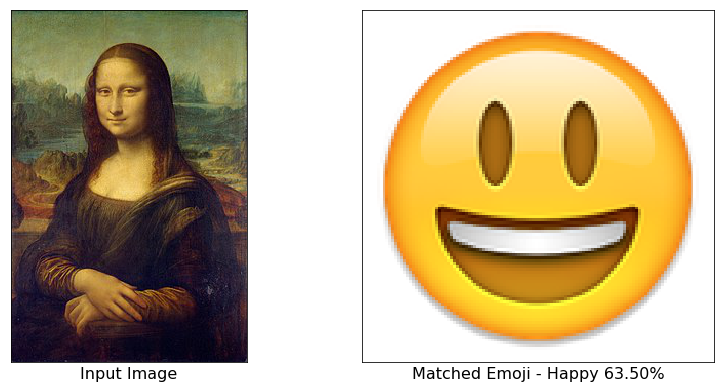

The Expression is Happy with the probability of 63.51 %


In [5]:
# Plot Original Image
plt.rcParams['figure.figsize'] = (13.5,5.5)
axes=plt.subplot(1, 2, 1)
plt.imshow(raw_img)
plt.xlabel('Input Image', fontsize=16)
axes.set_xticks([])
axes.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(left=0.05, bottom=0.2, right=0.95, top=0.9, hspace=0.02, wspace=0.3)
# Plot Emoji
axes=plt.subplot(1, 2, 2)
emojis_img = io.imread('images/emojis/%s.png' % str(class_names[int(predicted.cpu().numpy())]))
plt.imshow(emojis_img)
prob = score.data.cpu().numpy()[int(predicted.cpu().numpy())]*100
xtext = 'Matched Emoji - '+str(class_names[int(predicted.cpu().numpy())])+ ' '+str(prob)[0:5]+'%'
plt.xlabel(xtext, fontsize=16)
axes.set_xticks([])
axes.set_yticks([])
plt.tight_layout()

# Save result
plt.savefig(os.path.join('images/results/'+str(pic_name)+'_result.jpg'))
plt.show()
plt.close()
print("The Expression is %s with the probability of %.2f %%"
      %(str(class_names[int(predicted.cpu().numpy())]),prob))

In [6]:
for i in range(len(class_names)):
    print(class_names[i],':   \t', score.data.cpu().numpy()[i])

# plt.subplot(1,1,1)
# ind = 0.1+0.6*np.arange(len(class_names))    # the x locations for the groups
# width = 0.4       # the width of the bars: can also be len(x) sequence
# color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']
# for i in range(len(class_names)):
#     plt.bar(ind[i], score.data.cpu().numpy()[i], width, color=color_list[i])
#     print(class_names[i],':   \t', score.data.cpu().numpy()[i])
# plt.title("Classification results ",fontsize=20)
# plt.xlabel(" Expression Category ",fontsize=16)
# plt.ylabel(" Classification Score ",fontsize=16)
# plt.xticks(ind, class_names, rotation=45, fontsize=14)

Angry :   	 0.0023260668
Disgust :   	 0.0012535193
Fear :   	 0.0024693408
Happy :   	 0.63506013
Sad :   	 0.34267986
Surprise :   	 0.0013417971
Neutral :   	 0.014869388
